# Classify the Galaxies

## Set Up

In [1]:
#import all necessary libraries
import os

from pyspark.sql.functions import lit
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import IPython.display as dp
from pyspark.ml.image import ImageSchema
from sparkdl.image import imageIO

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from sparkdl import DeepImageFeaturizer

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("review_and_category_analytics") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

sqlCtx = SQLContext(sc)

Using TensorFlow backend.


In [2]:
import os
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.0.0-spark2.3-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [16]:
# os.environ

environ{'PATH': '/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'HOSTNAME': 'jupyter-chuqiao',
        'EMAIL': 'chuqiao@ucsb.edu',
        'JUPYTERHUB_HOST': '',
        'JUPYTERHUB_OAUTH_CALLBACK_URL': '/user/chuqiao/oauth_callback',
        'JUPYTERHUB_SERVICE_PREFIX': '/user/chuqiao/',
        'GIT_COMMITTER_NAME': 'chuqiao',
        'JUPYTERHUB_API_TOKEN': '39c2688d6dcc4044ab5e3e0b54809556',
        'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-chuqiao',
        'JUPYTERHUB_BASE_URL': '/',
        'CPU_GUARANTEE': '2.0',
        'JPY_API_TOKEN': '39c2688d6dcc4044ab5e3e0b54809556',
        'JUPYTERHUB_USER': 'chuqiao',
        'JUPYTERHUB_API_URL': 'http://10.27.244.140:8081/hub/api',
        'JUPYTER_IMAGE_SPEC': 'eespinosa/pyspark:v0.2',
        'GIT_AUTHOR_NAME': 'chuqiao',
        'JUPYTERHUB_ADMIN_ACCESS': '1',
        'MEM_LIMIT': '4294967296',
        'MEM_GUARANTEE': '2147483648',
        'CPU_LIMIT': '2.0',
        'KUBERNETES_PORT_443_TCP

## Create DataFrame of Images

### Verify Can Load Images

In [4]:
#small subset image directory
direc = "data/galaxy_images_classified/edge/"

fs = os.listdir(direc) #get list of image file names
fs.sort() #sort by file name

images = [] #create blank list which will store image objects

for ea in fs: #for each image in the list of images
    #add images object to the list of images
    images.append(dp.Image(filename=direc + ea, format="png"))

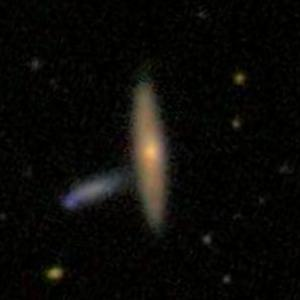

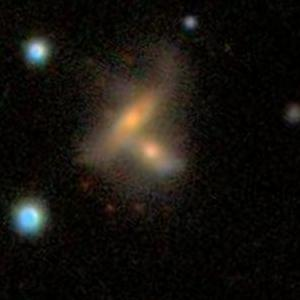

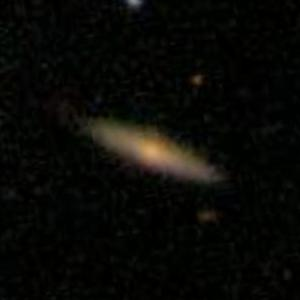

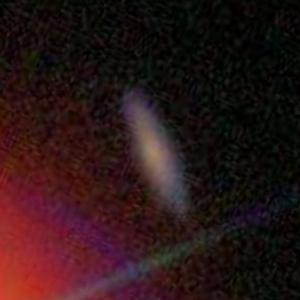

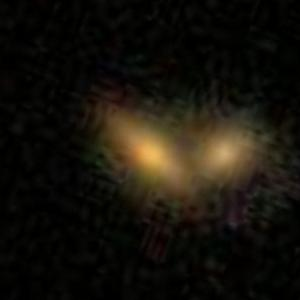

In [5]:
#Show first 5 images
for ea in range(5):
    dp.display_png(images[ea])

### Create Image DataFrames

#### IMPORTANT!!!! Change directory to full subset when not testing

In [4]:
#image_df = ImageSchema.readImages("data/galaxy_images_classified/[TYPE]")

smooth_df = ImageSchema.readImages("data/galaxy_images_classified/smooth_small/").withColumn("label", lit(1))
#edge_df = ImageSchema.readImages("data/galaxy_images_classified/edge/").withColumn("label", lit(2))
#spiral_df = ImageSchema.readImages("data/galaxy_images_classified/spiral/").withColumn("label", lit(3))
#other_df = ImageSchema.readImages("data/galaxy_images_classified/other/").withColumn("label", lit(0))

In [5]:
smooth_df = ImageSchema.readImages("data/galaxy_images_classified/smooth_small/")

In [6]:
smooth_subset = smooth_df.limit(10)
smooth_subset.cache()

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

In [7]:
smooth_subset.show()

+--------------------+
|               image|
+--------------------+
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
+--------------------+



In [8]:
smooth_train, smooth_test = smooth_subset.randomSplit([0.1, 0.9], seed=123)

In [9]:
#train log regression
featurizer = DeepImageFeaturizer(inputCol = "image",
                                outputCol = "features",
                                modelName = "InceptionV3")

In [10]:
#build log regression transform
lr = LogisticRegression(maxIter = 20, regParam = 0.05, 
                       elasticNetParam = 0.3, labelCol = "label")

In [11]:
#build pipeline
p = Pipeline(stages = [featurizer, lr])

In [15]:
#build model
p_model = p.fit(smooth_train)

INFO:tensorflow:Froze 376 variables.


2019-03-06 00:11:55,929 INFO (MainThread-207792) Froze 376 variables.


INFO:tensorflow:Converted 376 variables to const ops.


2019-03-06 00:11:56,152 INFO (MainThread-207792) Converted 376 variables to const ops.


IndexError: list index out of range

In [ ]:
from pyspark.ml.image import ImageSchema
from sparkdl import TFImageTransformer
import sparkdl.graph.utils as tfx  # strip_and_freeze_until was moved from sparkdl.transformers to sparkdl.graph.utils in 0.2.0
from sparkdl.transformers import utils
import tensorflow as tf

graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    image_arr = utils.imageInputPlaceholder()
    resized_images = tf.image.resize_images(image_arr, (299, 299))
    # the following step is not necessary for this graph, but can be for graphs with variables, etc
    frozen_graph = tfx.strip_and_freeze_until([resized_images], graph, sess, return_graph=True)

transformer = TFImageTransformer(inputCol="image", outputCol="predictions", graph=frozen_graph,
                                 inputTensor=image_arr, outputTensor=resized_images,
                                 outputMode="image")

image_df = ImageSchema.readImages(smooth_subset)
processed_image_df = transformer.transform(smooth_subset)

In [ ]:
#create train and test datasets for each galaxy type
smooth_train, smooth_test = smooth_df.randomSplit([0.1, 0.9], seed=123)
edge_train, edge_test = edge_df.randomSplit([0.1, 0.9], seed=123)
spiral_train, spiral_test = spiral_df.randomSplit([0.1, 0.9], seed=123)
other_train, other_test = other_df.randomSplit([0.1, 0.9], seed=123)

In [ ]:
#Add in other types of galaxies later!!!!!
train_df = smooth_train.unionAll(other_train)
test_df = smooth_test.unionAll(other_test)

In [ ]:
train_df = train_df.repartition(100)
test_df = test_df.repartition(100)

## Train the Model

In [ ]:
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)